In [14]:
# 2. Imports
import os
import shutil
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras import layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
from collections import Counter

In [15]:
# 3. Paths & Parameters
BASE_DIR = '/content/drive/MyDrive/wrist_xray_Xception'
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'val')

IMG_SIZE = (299, 299)  # Xception requires 299x299
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SEED = 42

In [16]:
# 4. Create train/val folders (same structure)
for split_dir in [train_dir, val_dir]:
    for cls in ['Normal', 'Fracture']:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)


In [17]:
# 5. Split & copy images (identical to previous versions)
for cls in ['Normal', 'Fracture']:
    src = os.path.join(BASE_DIR, cls)
    imgs = [f for f in os.listdir(src) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    train_imgs, val_imgs = train_test_split(imgs, test_size=VAL_SPLIT, random_state=SEED)

    for fname in train_imgs:
        shutil.copy(os.path.join(src, fname), os.path.join(train_dir, cls, fname))
    for fname in val_imgs:
        shutil.copy(os.path.join(src, fname), os.path.join(val_dir, cls, fname))
print("✅ Dataset split into train/val folders")

✅ Dataset split into train/val folders


In [18]:
# 6. Data Generators with Xception preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 153 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [19]:
# 7. Class Weight Calculation (same as before)
counts = Counter(train_gen.classes)
total = sum(counts.values())
class_weight = {k: total/(2*v) for k,v in counts.items()}
print("Class weights:", class_weight)


Class weights: {np.int32(0): 0.8693181818181818, np.int32(1): 1.176923076923077}


In [20]:
# 8. Build Xception Model
def build_model():
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )
    base_model.trainable = False

    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs, outputs)

model = build_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [21]:
# 9. Compile & Callbacks
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('best_xception.h5', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

In [22]:
# 10. Train Head
history_head = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weight,
    callbacks=callbacks
)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5510 - loss: 0.6729 - precision: 0.3407 - recall: 0.3275

5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.5529 - loss: 0.6804 - precision: 0.3637 - recall: 0.3293 - val_accuracy: 0.5750 - val_loss: 0.6355 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - accuracy: 0.6284 - loss: 0.6760 - precision: 0.5846 - recall: 0.3762

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6304 - loss: 0.6737 - precision: 0.5894 - recall: 0.3827 - val_accuracy: 0.8000 - val_loss: 0.6109 - val_precision: 0.7143 - val_recall: 0.8824 - learning_rate: 1.0000e-04
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.6412 - loss: 0.6613 - precision: 0.6197 - recall: 0.6559

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6444 - loss: 0.6558 - precision: 0.6135 - recall: 0.6645 - val_accuracy: 0.8000 - val_loss: 0.5935 - val_precision: 0.6800 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7428 - loss: 0.5748 - precision: 0.6524 - recall: 0.7847

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7443 - loss: 0.5762 - precision: 0.6562 - recall: 0.7873 - val_accuracy: 0.8000 - val_loss: 0.5628 - val_precision: 0.6957 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.6933 - loss: 0.5643 - precision: 0.5880 - recall: 0.8095

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6878 - loss: 0.5681 - precision: 0.5864 - recall: 0.7976 - val_accuracy: 0.8000 - val_loss: 0.5325 - val_precision: 0.6957 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7047 - loss: 0.5433 - precision: 0.6426 - recall: 0.7497

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7136 - loss: 0.5413 - precision: 0.6504 - recall: 0.7556 - val_accuracy: 0.8500 - val_loss: 0.5049 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.7437 - loss: 0.5653 - precision: 0.7634 - recall: 0.6241

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7439 - loss: 0.5634 - precision: 0.7569 - recall: 0.6278 - val_accuracy: 0.8500 - val_loss: 0.4850 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8163 - loss: 0.5139 - precision: 0.7875 - recall: 0.7683

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8121 - loss: 0.5152 - precision: 0.7806 - recall: 0.7685 - val_accuracy: 0.8500 - val_loss: 0.4702 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.8268 - loss: 0.4795 - precision: 0.7768 - recall: 0.7456

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8263 - loss: 0.4828 - precision: 0.7801 - recall: 0.7521 - val_accuracy: 0.8500 - val_loss: 0.4521 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.8126 - loss: 0.5006 - precision: 0.8459 - recall: 0.6620

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8166 - loss: 0.4967 - precision: 0.8477 - recall: 0.6748 - val_accuracy: 0.8500 - val_loss: 0.4404 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.8874 - loss: 0.4109 - precision: 0.8118 - recall: 0.9213

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8854 - loss: 0.4140 - precision: 0.8131 - recall: 0.9190 - val_accuracy: 0.8500 - val_loss: 0.4278 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.8901 - loss: 0.4279 - precision: 0.8349 - recall: 0.9498

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8801 - loss: 0.4303 - precision: 0.8202 - recall: 0.9428 - val_accuracy: 0.8500 - val_loss: 0.4164 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 13/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.8132 - loss: 0.4333 - precision: 0.7824 - recall: 0.8143

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8127 - loss: 0.4350 - precision: 0.7795 - recall: 0.8119 - val_accuracy: 0.8500 - val_loss: 0.4004 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 14/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8615 - loss: 0.3934 - precision: 0.7911 - recall: 0.9434

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8606 - loss: 0.3925 - precision: 0.7891 - recall: 0.9400 - val_accuracy: 0.8250 - val_loss: 0.3847 - val_precision: 0.7500 - val_recall: 0.8824 - learning_rate: 1.0000e-04
Epoch 15/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.8705 - loss: 0.4004 - precision: 0.8097 - recall: 0.9130

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8736 - loss: 0.3960 - precision: 0.8137 - recall: 0.9147 - val_accuracy: 0.8250 - val_loss: 0.3738 - val_precision: 0.7500 - val_recall: 0.8824 - learning_rate: 1.0000e-04
Epoch 16/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8626 - loss: 0.3832 - precision: 0.8544 - recall: 0.8034

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8550 - loss: 0.3874 - precision: 0.8427 - recall: 0.8002 - val_accuracy: 0.8500 - val_loss: 0.3678 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 17/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.8520 - loss: 0.3829 - precision: 0.8116 - recall: 0.8282

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8538 - loss: 0.3814 - precision: 0.8136 - recall: 0.8337 - val_accuracy: 0.8500 - val_loss: 0.3649 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 18/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.8481 - loss: 0.3675 - precision: 0.8012 - recall: 0.8729

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8506 - loss: 0.3664 - precision: 0.8034 - recall: 0.8735 - val_accuracy: 0.8500 - val_loss: 0.3602 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 19/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.8851 - loss: 0.3314 - precision: 0.8227 - recall: 0.9387

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8879 - loss: 0.3298 - precision: 0.8268 - recall: 0.9386 - val_accuracy: 0.8500 - val_loss: 0.3520 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 20/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8622 - loss: 0.3413 - precision: 0.7956 - recall: 0.9102

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8623 - loss: 0.3409 - precision: 0.7959 - recall: 0.9098 - val_accuracy: 0.8500 - val_loss: 0.3363 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 21/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.9080 - loss: 0.3243 - precision: 0.8625 - recall: 0.9259

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9070 - loss: 0.3264 - precision: 0.8652 - recall: 0.9203 - val_accuracy: 0.8500 - val_loss: 0.3283 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 22/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.8575 - loss: 0.3339 - precision: 0.8439 - recall: 0.8369

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8562 - loss: 0.3320 - precision: 0.8352 - recall: 0.8436 - val_accuracy: 0.8500 - val_loss: 0.3281 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 23/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.8752 - loss: 0.3204 - precision: 0.8292 - recall: 0.8849

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8753 - loss: 0.3188 - precision: 0.8307 - recall: 0.8836 - val_accuracy: 0.8500 - val_loss: 0.3234 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 24/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.8901 - loss: 0.2985 - precision: 0.8416 - recall: 0.8807

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8899 - loss: 0.2992 - precision: 0.8472 - recall: 0.8775 - val_accuracy: 0.8500 - val_loss: 0.3166 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 25/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.9193 - loss: 0.2739 - precision: 0.8689 - recall: 0.9617

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9175 - loss: 0.2772 - precision: 0.8708 - recall: 0.9527 - val_accuracy: 0.8500 - val_loss: 0.3120 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 26/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8952 - loss: 0.2741 - precision: 0.8800 - recall: 0.9150

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8953 - loss: 0.2730 - precision: 0.8726 - recall: 0.9189 - val_accuracy: 0.8500 - val_loss: 0.3119 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 27/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.9007 - loss: 0.2972 - precision: 0.8530 - recall: 0.9455

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8987 - loss: 0.2990 - precision: 0.8497 - recall: 0.9418 - val_accuracy: 0.8500 - val_loss: 0.3037 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 28/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9244 - loss: 0.2741 - precision: 0.8796 - recall: 0.9561

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9207 - loss: 0.2785 - precision: 0.8776 - recall: 0.9480 - val_accuracy: 0.8000 - val_loss: 0.2953 - val_precision: 0.7368 - val_recall: 0.8235 - learning_rate: 1.0000e-04
Epoch 29/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - accuracy: 0.8892 - loss: 0.2707 - precision: 0.8563 - recall: 0.8967

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8880 - loss: 0.2744 - precision: 0.8537 - recall: 0.8960 - val_accuracy: 0.8000 - val_loss: 0.2911 - val_precision: 0.7368 - val_recall: 0.8235 - learning_rate: 1.0000e-04
Epoch 30/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8305 - loss: 0.3099 - precision: 0.8413 - recall: 0.7793

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8348 - loss: 0.3099 - precision: 0.8396 - recall: 0.7879 - val_accuracy: 0.8500 - val_loss: 0.2893 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 1.0000e-04


In [23]:
# 11. Fine-Tuning Phase
# Unfreeze last 30 layers
model.trainable = True
for layer in model.layers[1].layers[:-30]:  # Keep early layers frozen
    layer.trainable = False

# Keep BatchNorm layers frozen
for layer in model.layers[1].layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    initial_epoch=history_head.epoch[-1],
    class_weight=class_weight,
    callbacks=callbacks
)

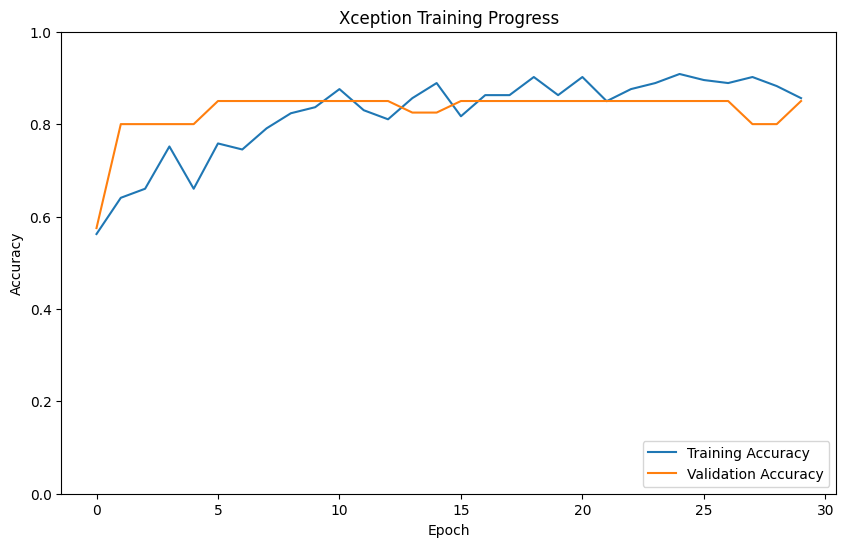

In [24]:
# 12. Version-safe Plotting (same as previous)
def plot_history(histories):
    key_mapping = {
        'train_acc': ['accuracy', 'acc'],
        'val_acc': ['val_accuracy', 'val_acc']
    }

    train_acc = []
    for hist in histories:
        for key in key_mapping['train_acc']:
            if key in hist.history:
                train_acc += hist.history[key]
                break

    val_acc = []
    for hist in histories:
        for key in key_mapping['val_acc']:
            if key in hist.history:
                val_acc += hist.history[key]
                break

    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title('Xception Training Progress')
    plt.show()

plot_history([history_head, history_fine])

In [25]:
# 13. Evaluation & Saving
model.load_weights('best_xception.h5')
loss, acc = model.evaluate(val_gen)
print(f"\n✅ Final Validation Accuracy: {acc*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8479 - loss: 0.2763

✅ Final Validation Accuracy: 85.00%


In [26]:
# 14. Save Model
model.save("/content/drive/MyDrive/xception_wrist_model.h5")

In [27]:
# 15. Prediction Function (Xception-specific preprocessing)
def predict_single_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = preprocess_input(img_array)  # Xception specific
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    label = 'Fracture' if prediction < 0.5 else 'Normal'

    plt.imshow(img)
    plt.title(f"Xception Prediction: {label} ({prediction:.4f})")
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


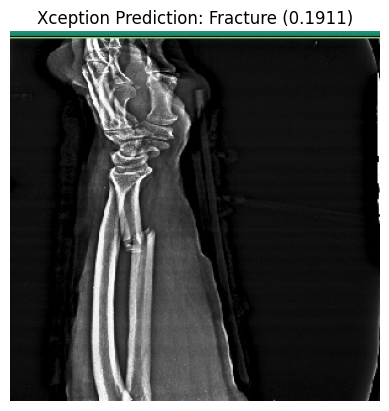

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


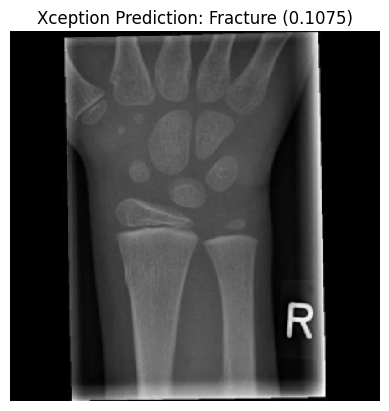

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


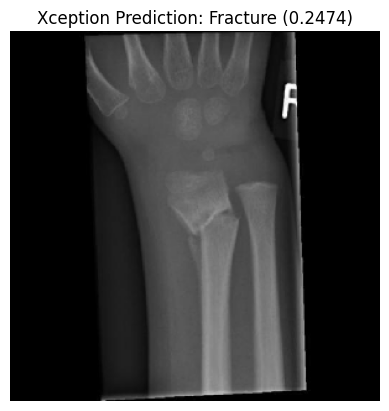

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


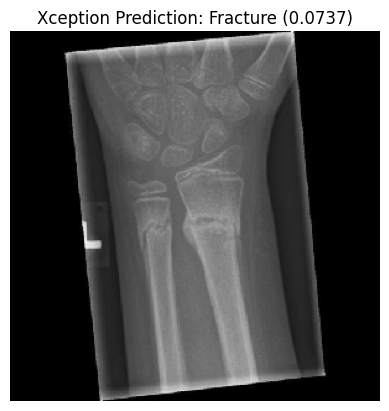

In [28]:
# Test prediction
predict_single_image('/content/drive/MyDrive/wrist_xray_Xception/Fracture/3 Male (L View).jpg')
predict_single_image('/content/drive/MyDrive/wrist_xray_Xception/196.jpg')
predict_single_image('/content/drive/MyDrive/wrist_xray_Xception/288.jpg')
predict_single_image('/content/drive/MyDrive/wrist_xray_Xception/346.jpg')
